In [ ]:
!git clone -b v3 https://github.com/jvnthny-espiritu/gramAI.git

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
data_dir = "/content/drive/MyDrive/thesis/data"
dibas_path = f"{data_dir}/raw/dibas"
clinical_path = f"{data_dir}/raw/clinical-pb"
results_path = f"{data_dir}/results"
dibas_data = f"{data_dir}/augmented/dibas"
clinical_data = f"{data_dir}/augmented/clinical_pb"

## Extra code

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("gram_image_stats.csv")

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(df['brightness'], kde=True, color='gold')
plt.title("Brightness")

plt.subplot(2, 2, 2)A
sns.histplot(df['contrast'], kde=True, color='darkblue')
plt.title("Contrast")

plt.subplot(2, 2, 3)
sns.histplot(df['edge_density'], kde=True, color='slategray')
plt.title("Edge Density")

plt.subplot(2, 2, 4)
sns.scatterplot(data=df, x='mean_Hue', y='mean_Sat', color='darkgreen')
plt.title("Hue vs. Saturation")

plt.tight_layout()
plt.suptitle("Gram-Stained Image Dataset — Preprocessing Analysis", fontsize=16, y=1.02)
plt.show()


# AE Model

## Model Training

In [53]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

# 1. Custom Dataset (now skips invalid images)
class GramImages(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.imgs = []
        for f in os.listdir(img_dir):
            if not f.lower().endswith(('.png','.jpg','.jpeg', '.tif')):
                continue
            fp = os.path.join(img_dir, f)
            try:
                with Image.open(fp) as img:
                    img.verify()  # Check if image is corrupted
                self.imgs.append(fp)
            except Exception:
                continue  # Skip invalid/corrupted images

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = Image.open(self.imgs[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# 2. Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 3. DataLoader
train_dir = dibas_data
train_ds = GramImages(train_dir, transform=transform)
val_ratio = 0.2  # 20% of data for validation
val_size = int(len(train_ds) * val_ratio)
train_size = len(train_ds) - val_size

train_subset, val_subset = random_split(train_ds, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

In [30]:
# 4. CAE Model (as provided)
class CAE(nn.Module):
    def __init__(self, latent_dim=64, dropout=0.2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, latent_dim)

        self.fc2 = nn.Linear(latent_dim, 128 * 16 * 16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(64, 32, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, 3, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        flat = self.flatten(z)
        latent = self.fc1(flat)
        out = self.fc2(latent).view(-1, 128, 16, 16)
        reconstructed = self.decoder(out)
        return reconstructed, latent

In [54]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, verbose=False, path=None):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss =np.inf
        self.early_stop = False
        self.path = path
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_wts = model.state_dict()
            if self.verbose:
                print(f"Validation loss decreased. Saving new best model (loss: {val_loss:.4f})")
            if self.path:
                torch.save(model.state_dict(), self.path)
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [55]:
def evaluate(model, val_loader, criterion=None, device='cpu'):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs in val_loader:
            imgs = imgs.to(device)
            outputs, _ = model(imgs)
            loss = criterion(outputs, imgs) if criterion else nn.MSELoss()(outputs, imgs)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    model.train()
    return val_loss

In [56]:
# 5. Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CAE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopping = EarlyStopping(patience=7, min_delta=1e-4, verbose=True, path='best_model.pt')

for epoch in range(100):  # Set number of epochs as needed
    model.train()
    running_loss = 0.0
    for imgs in train_loader:
        imgs = imgs.to(device)
        outputs, latents = model(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/10], Loss: {running_loss/len(train_loader):.4f}")

    val_loss = evaluate(model, val_loader, criterion, device)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Optionally, load the best model after training
if early_stopping.path:
    model.load_state_dict(torch.load('best_model.pt'))

Epoch [1/10], Loss: 0.0785
Validation loss decreased. Saving new best model (loss: 0.0697)
Epoch [2/10], Loss: 0.0650
Validation loss decreased. Saving new best model (loss: 0.0634)
Epoch [3/10], Loss: 0.0619
Validation loss decreased. Saving new best model (loss: 0.0622)
Epoch [4/10], Loss: 0.0605
Validation loss decreased. Saving new best model (loss: 0.0613)
Epoch [5/10], Loss: 0.0598
Validation loss decreased. Saving new best model (loss: 0.0603)
Epoch [6/10], Loss: 0.0592
EarlyStopping counter: 1 of 7
Epoch [7/10], Loss: 0.0587
Validation loss decreased. Saving new best model (loss: 0.0597)
Epoch [8/10], Loss: 0.0580
EarlyStopping counter: 1 of 7
Epoch [9/10], Loss: 0.0577
Validation loss decreased. Saving new best model (loss: 0.0591)
Epoch [10/10], Loss: 0.0574
Validation loss decreased. Saving new best model (loss: 0.0587)
Epoch [11/10], Loss: 0.0569
EarlyStopping counter: 1 of 7
Epoch [12/10], Loss: 0.0568
EarlyStopping counter: 2 of 7
Epoch [13/10], Loss: 0.0564
EarlyStopping

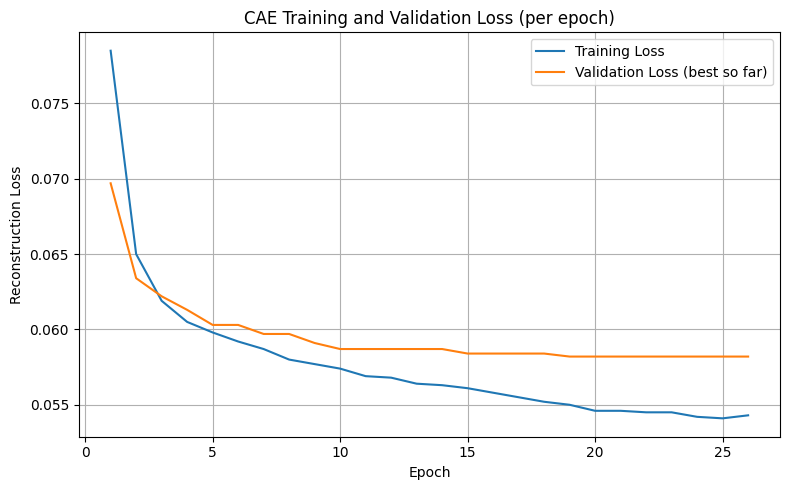

=== CAE Loss Report ===
Final Training Loss: 0.0543
Best Validation Loss: 0.0582
Generalization Gap: 0.0039


In [47]:
import re
import matplotlib.pyplot as plt
import pandas as pd

log_path = "cae_training_log.txt"

# Patterns
train_loss_re = re.compile(r"Epoch \[(\d+)/\d+\], Loss: ([0-9.]+)")
val_loss_re = re.compile(r"Saving new best model \(loss: ([0-9.]+)\)")

train_losses = []
val_loss_updates = {}  # epoch: val_loss

# Temporary holders
last_epoch = None

with open(log_path, "r") as f:
    for line in f:
        train_match = train_loss_re.search(line)
        if train_match:
            last_epoch = int(train_match.group(1))
            train_loss = float(train_match.group(2))
            train_losses.append((last_epoch, train_loss))
        val_match = val_loss_re.search(line)
        if val_match and last_epoch is not None:
            val_loss = float(val_match.group(1))
            # Assign this validation loss to the most recent epoch
            val_loss_updates[last_epoch] = val_loss

# Now align validation losses with every epoch, carry forward previous best if not updated
val_losses = []
current_val_loss = None
epochs = [ep for (ep, _) in train_losses]
for ep in epochs:
    if ep in val_loss_updates:
        current_val_loss = val_loss_updates[ep]
    val_losses.append(current_val_loss)

train_losses_only = [loss for (_, loss) in train_losses]

# Plot
plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses_only, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss (best so far)")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.title("CAE Training and Validation Loss (per epoch)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("cae_loss_curve_full.png")
plt.show()

# Save to CSV
df = pd.DataFrame({"epoch": epochs, "train_loss": train_losses_only, "val_loss": val_losses})
df.to_csv("cae_loss_per_epoch.csv", index=False)

# Print final report
final_train_loss = train_losses_only[-1]
best_val_loss = min([v for v in val_losses if v is not None])
generalization_gap = abs(best_val_loss - final_train_loss)

print("=== CAE Loss Report ===")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Generalization Gap: {generalization_gap:.4f}")

## Latent Features Extraction

In [26]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

class CombinedImageFolderDataset(Dataset):
    def __init__(self, folders, image_size):
        self.paths = []
        for folder in folders:
            self.paths.extend(glob(os.path.join(folder, '*')))
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
        ])
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        return self.transform(img)

In [36]:
folders = [dibas_data, clinical_data]
DATASET = CombinedImageFolderDataset(folders, (128, 128))

In [37]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import os
from glob import glob
from PIL import Image

# --- User configuration ---
MODEL_PATH = 'best_model.pt'      # Path to the trained autoencoder
AUGMENTED_DIR = f'{data_dir}/augmented/dibas'
RESULTS_DIR = f'{data_dir}/results'
LATENT_OUT_PATH = os.path.join(RESULTS_DIR, 'latent_features.npy')
BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = (128, 128)

# --- Dataset class ---
class ImageFolderDataset(Dataset):
    def __init__(self, folder, image_size):
        self.paths = glob(os.path.join(folder, '*'))
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
        ])
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        return self.transform(img)

# --- Main extraction script ---
if __name__ == "__main__":
    # 1. Instantiate and load model
    model = CAE(latent_dim=64)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval().to(DEVICE)

    # 2. Data loader
    # dataset = ImageFolderDataset(DATASET, IMG_SIZE)
    loader = DataLoader(DATASET, batch_size=BATCH_SIZE, shuffle=False)

    # 3. Ensure results directory exists
    os.makedirs(RESULTS_DIR, exist_ok=True)

    # 4. Extract and save latent features
    all_latents = []
    with torch.no_grad():
        for imgs in loader:
            imgs = imgs.to(DEVICE)
            _, latents = model(imgs)
            all_latents.append(latents.cpu().numpy())

    all_latents = np.concatenate(all_latents, axis=0)
    np.save(LATENT_OUT_PATH, all_latents)
    print(f"Saved latent features for {len(all_latents)} images to {LATENT_OUT_PATH}")

Saved latent features for 7440 images to /content/drive/MyDrive/thesis/data/results/latent_features.npy


# Clustering

Loaded latent features: shape = (7440, 64)
n_clusters = 2: silhouette_score = 0.1980
n_clusters = 3: silhouette_score = 0.2844
n_clusters = 4: silhouette_score = 0.2446
n_clusters = 5: silhouette_score = 0.2244
n_clusters = 6: silhouette_score = 0.2197
n_clusters = 7: silhouette_score = 0.2101
n_clusters = 8: silhouette_score = 0.2086
n_clusters = 9: silhouette_score = 0.2026
n_clusters = 10: silhouette_score = 0.1822


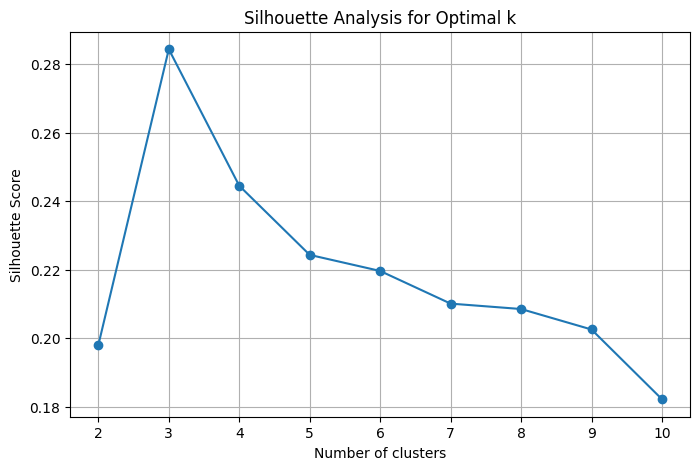

Best number of clusters by silhouette score: 3
Saved cluster assignments for 7440 samples to /content/drive/MyDrive/thesis/data/results/cluster_assignments.npy

=== Cluster Distribution ===
Cluster 0: 1912 samples
Cluster 1: 1913 samples
Cluster 2: 3615 samples


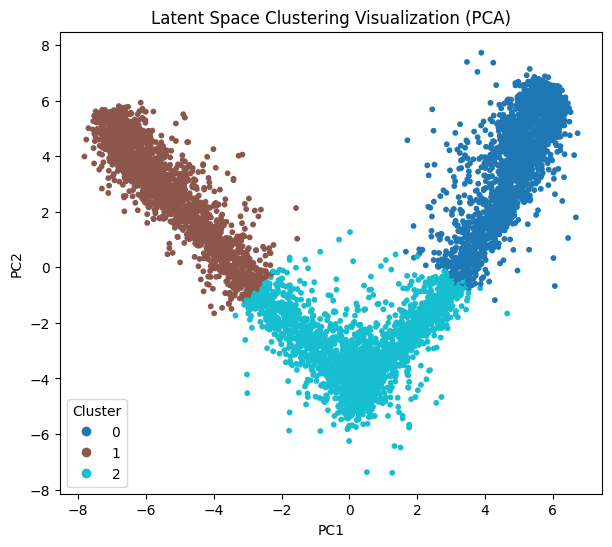

In [38]:
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# --- Config ---
LATENT_FEATURES_PATH = os.path.join(results_path, "latent_features.npy")
CLUSTER_ASSIGNMENTS_PATH = os.path.join(results_path, "cluster_assignments.npy")
N_CLUSTERS_TRY = list(range(2, 11))  # Try 2 to 10 clusters

# --- Load latent features ---
latents = np.load(LATENT_FEATURES_PATH)
print(f"Loaded latent features: shape = {latents.shape}")

# --- Find optimal number of clusters using silhouette score ---
silhouette_scores = []
for n_clusters in N_CLUSTERS_TRY:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latents)
    score = silhouette_score(latents, cluster_labels)
    silhouette_scores.append(score)
    print(f"n_clusters = {n_clusters}: silhouette_score = {score:.4f}")

# --- Plot silhouette scores for analysis ---
plt.figure(figsize=(8, 5))
plt.plot(N_CLUSTERS_TRY, silhouette_scores, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for Optimal k")
plt.grid()
plt.savefig(os.path.join(results_path, "silhouette_analysis.png"))
plt.show()

# --- Choose best k and fit final KMeans ---
best_k = N_CLUSTERS_TRY[np.argmax(silhouette_scores)]
print(f"Best number of clusters by silhouette score: {best_k}")
kmeans = KMeans(n_clusters=best_k, random_state=42)
final_labels = kmeans.fit_predict(latents)

# --- Save cluster assignments ---
np.save(CLUSTER_ASSIGNMENTS_PATH, final_labels)
print(f"Saved cluster assignments for {len(final_labels)} samples to {CLUSTER_ASSIGNMENTS_PATH}")

# --- Cluster analysis ---
# Count samples per cluster
unique, counts = np.unique(final_labels, return_counts=True)
print("\n=== Cluster Distribution ===")
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")

# Optional: PCA for 2D visualization
try:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    latents_2d = pca.fit_transform(latents)
    plt.figure(figsize=(7,6))
    scatter = plt.scatter(latents_2d[:,0], latents_2d[:,1], c=final_labels, cmap='tab10', s=10)
    plt.legend(*scatter.legend_elements(), title="Cluster")
    plt.title("Latent Space Clustering Visualization (PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.savefig(os.path.join(results_path, "latent_space_clusters_pca.png"))
    plt.show()
except ImportError:
    print("PCA visualization skipped (scikit-learn required).")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KMeans silhouette: 0.284417
Agglomerative silhouette: 0.22830959
GMM silhouette: 0.04155979
Spectral silhouette: 0.2820025
DBSCAN silhouette: None
HDBSCAN silhouette: None


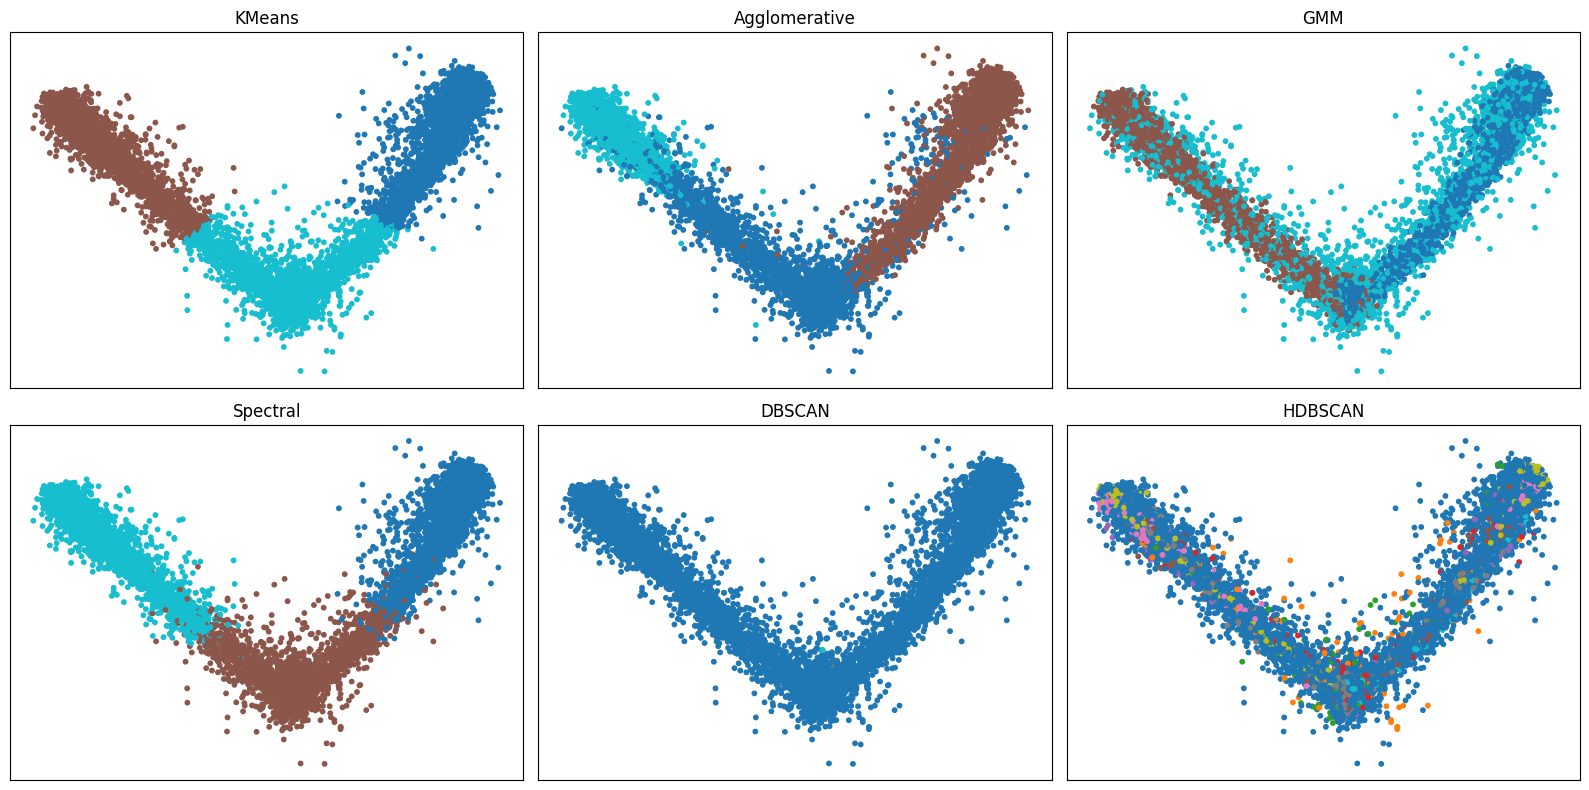

In [39]:
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load latent features
latents = np.load(LATENT_FEATURES_PATH)

# 1. KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(latents)

# 2. Agglomerative (Hierarchical) clustering
agglo = AgglomerativeClustering(n_clusters=3, linkage='ward')
agglo_labels = agglo.fit_predict(latents)

# 3. Gaussian Mixture Model (soft clustering)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(latents)

# 4. Spectral Clustering
spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral.fit_predict(latents)

# 5. DBSCAN (density-based, does not require n_clusters)
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=3)
dbscan_labels = dbscan.fit_predict(latents)

# 6. HDBSCAN (variable density, requires pip install hdbscan)
try:
    import hdbscan
    hdb = hdbscan.HDBSCAN(min_cluster_size=2)
    hdb_labels = hdb.fit_predict(latents)
except ImportError:
    hdb_labels = None
    print("HDBSCAN not installed. Skipping.")

# --- Example: Evaluate clustering using silhouette score (if >1 cluster) ---
def safe_silhouette(X, labels):
    if len(set(labels)) > 1 and (min(labels) >= 0):  # DBSCAN may assign -1 for noise
        return silhouette_score(X, labels)
    return None

print("KMeans silhouette:", safe_silhouette(latents, kmeans_labels))
print("Agglomerative silhouette:", safe_silhouette(latents, agglo_labels))
print("GMM silhouette:", safe_silhouette(latents, gmm_labels))
print("Spectral silhouette:", safe_silhouette(latents, spectral_labels))
print("DBSCAN silhouette:", safe_silhouette(latents, dbscan_labels))
if hdb_labels is not None:
    print("HDBSCAN silhouette:", safe_silhouette(latents, hdb_labels))

# --- Optional: Visualize clusters using PCA (2D projection) ---
from sklearn.decomposition import PCA
latents_2d = PCA(n_components=2).fit_transform(latents)
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
clusterings = [
    ("KMeans", kmeans_labels),
    ("Agglomerative", agglo_labels),
    ("GMM", gmm_labels),
    ("Spectral", spectral_labels),
    ("DBSCAN", dbscan_labels),
    ("HDBSCAN", hdb_labels if hdb_labels is not None else np.zeros_like(kmeans_labels)),
]
for ax, (name, labels) in zip(axes.flat, clusterings):
    sc = ax.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', s=10)
    ax.set_title(name)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig(f"{results_path}/clustering_comparison_pca.png")
plt.show()

# Classifier Model

## Random Forest Classifier

In [40]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Load latent features and cluster assignments
latents = np.load(f"{results_path}/latent_features.npy")
clusters = np.load(f"{results_path}/cluster_assignments.npy")  # From clustering step

# Split (for demonstration)
X_train, X_test, y_train, y_test = train_test_split(latents, clusters, test_size=0.2, random_state=42)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9879032258064516
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       409
           1       0.99      0.99      0.99       368
           2       0.99      0.99      0.99       711

    accuracy                           0.99      1488
   macro avg       0.99      0.99      0.99      1488
weighted avg       0.99      0.99      0.99      1488



In [41]:
import joblib
joblib.dump(clf, f'{results_path}/latent_rf_classifier.joblib')

['/content/drive/MyDrive/thesis/data/results/latent_rf_classifier.joblib']

## MLP Classifier

In [42]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# --- Config ---
LATENTS_PATH = f"{results_path}/latent_features.npy"
PSEUDO_LABELS_PATH = f"{results_path}/cluster_assignments.npy"  # Use clusters as pseudo-labels
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 1e-3

# --- Load features and (pseudo-)labels ---
latents = np.load(LATENTS_PATH)
labels = np.load(PSEUDO_LABELS_PATH)

X_train, X_test, y_train, y_test = train_test_split(latents, labels, test_size=0.2, random_state=42)

# --- Torch datasets ---
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# --- Simple MLP model ---
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.model(x)

input_dim = latents.shape[1]
num_classes = len(np.unique(labels))
model = MLP(input_dim, num_classes).to(DEVICE)

# --- Training setup ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Training loop ---
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")

# --- Evaluation ---
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        preds = model(xb).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(yb.numpy())

print("\nMLP Classifier on Latent Features (using clusters as labels):")
print(classification_report(all_targets, all_preds))
print("Accuracy:", accuracy_score(all_targets, all_preds))

Epoch 1/30 - Loss: 0.2515
Epoch 2/30 - Loss: 0.0534
Epoch 3/30 - Loss: 0.0396
Epoch 4/30 - Loss: 0.0347
Epoch 5/30 - Loss: 0.0278
Epoch 6/30 - Loss: 0.0272
Epoch 7/30 - Loss: 0.0257
Epoch 8/30 - Loss: 0.0255
Epoch 9/30 - Loss: 0.0212
Epoch 10/30 - Loss: 0.0175
Epoch 11/30 - Loss: 0.0202
Epoch 12/30 - Loss: 0.0163
Epoch 13/30 - Loss: 0.0161
Epoch 14/30 - Loss: 0.0140
Epoch 15/30 - Loss: 0.0163
Epoch 16/30 - Loss: 0.0150
Epoch 17/30 - Loss: 0.0156
Epoch 18/30 - Loss: 0.0174
Epoch 19/30 - Loss: 0.0162
Epoch 20/30 - Loss: 0.0110
Epoch 21/30 - Loss: 0.0133
Epoch 22/30 - Loss: 0.0133
Epoch 23/30 - Loss: 0.0173
Epoch 24/30 - Loss: 0.0188
Epoch 25/30 - Loss: 0.0090
Epoch 26/30 - Loss: 0.0116
Epoch 27/30 - Loss: 0.0112
Epoch 28/30 - Loss: 0.0105
Epoch 29/30 - Loss: 0.0129
Epoch 30/30 - Loss: 0.0113

MLP Classifier on Latent Features (using clusters as labels):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       409
           1       0.99    

Epoch 1/30 - Loss: 0.2239
Epoch 2/30 - Loss: 0.0478
Epoch 3/30 - Loss: 0.0408
Epoch 4/30 - Loss: 0.0327
Epoch 5/30 - Loss: 0.0275
Epoch 6/30 - Loss: 0.0313
Epoch 7/30 - Loss: 0.0255
Epoch 8/30 - Loss: 0.0216
Epoch 9/30 - Loss: 0.0213
Epoch 10/30 - Loss: 0.0199
Epoch 11/30 - Loss: 0.0192
Epoch 12/30 - Loss: 0.0189
Epoch 13/30 - Loss: 0.0163
Epoch 14/30 - Loss: 0.0166
Epoch 15/30 - Loss: 0.0161
Epoch 16/30 - Loss: 0.0174
Epoch 17/30 - Loss: 0.0147
Epoch 18/30 - Loss: 0.0197
Epoch 19/30 - Loss: 0.0179
Epoch 20/30 - Loss: 0.0134
Epoch 21/30 - Loss: 0.0160
Epoch 22/30 - Loss: 0.0130
Epoch 23/30 - Loss: 0.0216
Epoch 24/30 - Loss: 0.0094
Epoch 25/30 - Loss: 0.0101
Epoch 26/30 - Loss: 0.0138
Epoch 27/30 - Loss: 0.0124
Epoch 28/30 - Loss: 0.0142
Epoch 29/30 - Loss: 0.0075
Epoch 30/30 - Loss: 0.0106

## Table X. MLP Architecture Details

| Layer     | Output Size | Activation | Dropout |
|-----------|-------------|------------|---------|
| Input     | 64          |    -       |   -     |
| Linea

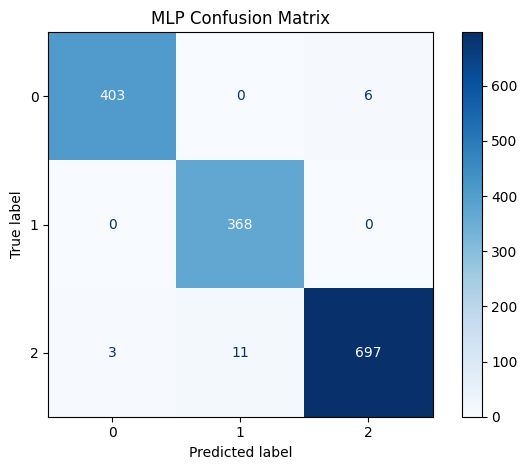

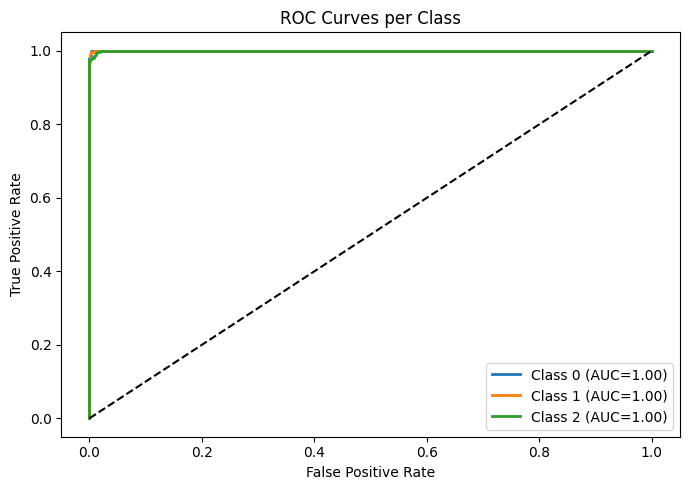


## Table Z. Feature Importance (first layer, mean abs weight)
|   Feature (latent idx) |   Mean(|weight|) |
|-----------------------:|-----------------:|
|                0.00000 |          0.10035 |
|                1.00000 |          0.07243 |
|                2.00000 |          0.07564 |
|                3.00000 |          0.07852 |
|                4.00000 |          0.07016 |
|                5.00000 |          0.07369 |
|                6.00000 |          0.10543 |
|                7.00000 |          0.05939 |
|                8.00000 |          0.06835 |
|                9.00000 |          0.09015 |
Full table saved as 'mlp_feature_importance.csv'.


In [56]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import pandas as pd

# --- Config ---
LATENTS_PATH = f"{results_path}/latent_features.npy"
PSEUDO_LABELS_PATH = f"{results_path}/cluster_assignments.npy"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 1e-3

# --- Load features and (pseudo-)labels ---
latents = np.load(LATENTS_PATH)
labels = np.load(PSEUDO_LABELS_PATH)

input_dim = latents.shape[1]
num_classes = len(np.unique(labels))

X_train, X_test, y_train, y_test = train_test_split(latents, labels, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# --- MLP Model ---
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.model(x)

model = MLP(input_dim, num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Training loop ---
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")

# --- Evaluation ---
model.eval()
all_preds, all_targets, all_probs = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = logits.argmax(dim=1).cpu().numpy()
        all_probs.append(probs)
        all_preds.extend(preds)
        all_targets.extend(yb.numpy())
all_probs = np.vstack(all_probs)

# --- Table X: MLP Architecture ---
print("\n## Table X. MLP Architecture Details\n")
print("| Layer     | Output Size | Activation | Dropout |")
print("|-----------|-------------|------------|---------|")
print(f"| Input     | {input_dim:<11} |    -       |   -     |")
print(f"| Linear 1  | 128         |   ReLU     |   0.2   |")
print(f"| Linear 2  | 64          |   ReLU     |   0.2   |")
print(f"| Output    | {num_classes:<11} |    -       |   -     |")
print("\n*Optimizer: Adam, LR: 1e-3, Loss: CrossEntropyLoss, Epochs: 30, Batch size: 64*\n")

# --- Table Y: Classification Performance ---
print("## Table Y. MLP Classifier Performance\n")
report = classification_report(all_targets, all_preds, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report.to_markdown(floatfmt=".3f"))
print(f"\nAccuracy: {accuracy_score(all_targets, all_preds):.3f}\n")

# --- Figure A: Confusion Matrix ---
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("MLP Confusion Matrix")
plt.tight_layout()
plt.savefig("mlp_confusion_matrix.png")
plt.show()

# --- Figure B: ROC Curves (optional, only if num_classes <= 10) ---
if num_classes <= 10:
    y_true_bin = label_binarize(all_targets, classes=np.arange(num_classes))
    plt.figure(figsize=(7,5))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC={roc_auc:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves per Class')
    plt.legend()
    plt.tight_layout()
    plt.savefig("mlp_roc_curves.png")
    plt.show()
else:
    print("Too many classes for ROC curves (skipped).")

# --- Table Z: Feature Importance (first layer, abs mean) ---
first_layer_weights = model.model[0].weight.detach().cpu().numpy()
feature_importance = np.abs(first_layer_weights).mean(axis=0)
df_feat = pd.DataFrame({
    'Feature (latent idx)': np.arange(len(feature_importance)),
    'Mean(|weight|)': feature_importance
})
df_feat.to_csv('mlp_feature_importance.csv', index=False)
print("\n## Table Z. Feature Importance (first layer, mean abs weight)")
print(df_feat.head(10).to_markdown(index=False, floatfmt=".5f"))
print("Full table saved as 'mlp_feature_importance.csv'.")

In [ ]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms

# --- Load trained CAE encoder ---
# Assume cae_encoder is your encoder part (torch.nn.Module)
cae_encoder = ...  # Load your trained encoder weights
cae_encoder.eval()

# --- Load trained classifier (e.g., MLP) ---
mlp_classifier = ...  # Load your trained classifier model
mlp_classifier.eval()

# --- (Or if using scikit-learn) ---
# from sklearn.externals import joblib
# rf_classifier = joblib.load('path/to/rf_classifier.joblib')

# --- Preprocessing function ---
def preprocess_image(img_path, img_size):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        # Optionally add normalization if you used it in training
    ])
    return transform(img).unsqueeze(0)  # Shape: (1, C, H, W)

def predict(img_path, img_size=(128, 128)):
    # 1. Preprocess image
    x = preprocess_image(img_path, img_size)

    # 2. Get latent vector from encoder
    with torch.no_grad():
        latent = cae_encoder(x).cpu().numpy()

    # 3. Classify
    # For PyTorch MLP
    with torch.no_grad():
        logits = mlp_classifier(torch.tensor(latent, dtype=torch.float32))
        pred_class = logits.argmax(dim=1).item()
    # For RandomForest
    # pred_class = rf_classifier.predict(latent)[0]

    return pred_class

# --- Example usage ---
img_path = "path/to/test_image.jpg"
pred = predict(img_path)
print(f"Predicted class/cluster: {pred}")

# Analysis

In [15]:
import os
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import fnmatch

IMG_EXTENSIONS = (".png", ".jpg", ".jpeg", ".tif")
IMG_SIZE = (128, 128)
N_THREADS = 8

def is_image_file(filename):
    return filename.lower().endswith(IMG_EXTENSIONS)

def load_image(path):
    try:
        img = cv2.imread(str(path))
        if img is None:
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        return img
    except Exception:
        return None

def get_image_paths(root_dir):
    paths = []
    for dirpath, _, filenames in os.walk(root_dir):
        for fname in filenames:
            if is_image_file(fname):
                paths.append(Path(dirpath) / fname)
    return paths

def select_named_samples(img_paths, pattern, count):
    matches = [str(p) for p in img_paths if fnmatch.fnmatch(os.path.basename(str(p)), pattern)]
    return matches[:count]

def analyze_image(img, path="unknown"):
    analysis = {}

    # Color histogram (keep for plotting)
    hist_r = cv2.calcHist([img], [0], None, [256], [0,256])
    hist_g = cv2.calcHist([img], [1], None, [256], [0,256])
    hist_b = cv2.calcHist([img], [2], None, [256], [0,256])
    analysis['hist_r'] = hist_r.squeeze()
    analysis['hist_g'] = hist_g.squeeze()
    analysis['hist_b'] = hist_b.squeeze()

    # Edge map (Canny)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    analysis['edges'] = edges

    # Object count (connected components)
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    num_labels, _ = cv2.connectedComponents(bw)
    analysis['object_count'] = num_labels - 1

    # Image quality: blurriness
    analysis['blurriness'] = cv2.Laplacian(gray, cv2.CV_64F).var()

    # Image quality: contrast
    analysis['contrast'] = gray.std()

    # Extended statistics
    analysis['path'] = path
    analysis['mean_R'] = np.mean(img[:,:,0])
    analysis['mean_G'] = np.mean(img[:,:,1])
    analysis['mean_B'] = np.mean(img[:,:,2])
    analysis['std_R'] = np.std(img[:,:,0])
    analysis['std_G'] = np.std(img[:,:,1])
    analysis['std_B'] = np.std(img[:,:,2])

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    analysis['mean_Hue'] = np.mean(hsv[:,:,0])
    analysis['std_Hue']  = np.std(hsv[:,:,0])
    analysis['mean_Sat'] = np.mean(hsv[:,:,1])
    analysis['std_Sat']  = np.std(hsv[:,:,1])

    analysis['brightness'] = np.mean(gray)
    analysis['edge_density'] = np.mean(edges > 0)

    return analysis

def run_all_analyses(img_dir):
    img_paths = get_image_paths(img_dir)
    all_analyses = []
    sample_visuals = []

    # Select 2 Escherichia.coli and 2 Staphylococcus.aureus images for visualization
    sample_1 = select_named_samples(img_paths, "S.WORM G1.jpg", 1)
    sample_2 = select_named_samples(img_paths, "A3_PDC.jpg", 1)
    sample_3 = select_named_samples(img_paths, "SWORM G2.jpg", 1)
    sample_4 = select_named_samples(img_paths, "SOIL G4.jpg", 1)
    sample_paths = sample_1 + sample_2 + sample_3 + sample_4
    sample_path_set = set(sample_paths)

    def process_path(path):
        img = load_image(path)
        if img is None:
            return None
        res = analyze_image(img, path=str(path))
        res['img'] = img
        return res

    with ThreadPoolExecutor(max_workers=N_THREADS) as executor:
        results = list(tqdm(executor.map(process_path, img_paths), total=len(img_paths), desc="Analyzing images"))

    for res in results:
        if res is None:
            continue
        if res['path'] in sample_path_set:
            sample_visuals.append(res)
        # Remove the image from the result to save memory before exporting
        res_noimg = {k: v for k, v in res.items() if k != 'img'}
        all_analyses.append(res_noimg)

    # Maintain order: Escherichia first, Staph second
    sample_visuals_sorted = []
    for path in sample_paths:
        for res in sample_visuals:
            if res['path'] == path:
                sample_visuals_sorted.append(res)
    return all_analyses, sample_visuals_sorted, sample_paths

def plot_individual_analysis_grid(analysis, idx, save_dir):
    img = analysis['img']
    filename = os.path.basename(analysis['path'])

    # Prepare info text with all statistics
    info = (
        f"Filename: {filename}\n"
        f"mean_R: {analysis['mean_R']:.2f}  mean_G: {analysis['mean_G']:.2f}  mean_B: {analysis['mean_B']:.2f}\n"
        f"std_R: {analysis['std_R']:.2f}  std_G: {analysis['std_G']:.2f}  std_B: {analysis['std_B']:.2f}\n"
        f"mean_Hue: {analysis['mean_Hue']:.2f}  std_Hue: {analysis['std_Hue']:.2f}\n"
        f"mean_Sat: {analysis['mean_Sat']:.2f}  std_Sat: {analysis['std_Sat']:.2f}\n"
        f"brightness: {analysis['brightness']:.2f}  contrast: {analysis['contrast']:.2f}\n"
        f"object count: {analysis['object_count']}\n"
        f"blurriness: {analysis['blurriness']:.2f}\n"
        f"edge_density: {analysis['edge_density']:.6f}"
    )

    fig, axs = plt.subplots(2, 3, figsize=(17, 10), gridspec_kw={'width_ratios': [1, 1, 1.3]})

    # Row 1: Image | Color Histogram | Info
    axs[0,0].imshow(img)
    axs[0,0].set_title("Original Image")
    axs[0,0].axis('off')

    axs[0,1].bar(range(256), analysis['hist_r'], color='r', alpha=0.5, label='R')
    axs[0,1].bar(range(256), analysis['hist_g'], color='g', alpha=0.5, label='G')
    axs[0,1].bar(range(256), analysis['hist_b'], color='b', alpha=0.5, label='B')
    axs[0,1].set_title("Color Histogram")
    axs[0,1].set_xlim(0,255)

    for a in [axs[0,2], axs[1,2]]:
        a.axis('off')
    axs[0,2].text(0.01, 0.97, info, fontsize=12, va="top", fontfamily='monospace')

    # Row 2: Edge map | Edge hist | Info
    axs[1,0].imshow(analysis['edges'], cmap='gray')
    axs[1,0].set_title("Edge Map")
    axs[1,0].axis('off')

    axs[1,1].hist(analysis['edges'].flatten(), bins=40, color='black', alpha=0.8)
    axs[1,1].set_title("Edge Value Histogram")

    # Repeat the info for balance
    axs[1,2].text(0.01, 0.97, info, fontsize=12, va="top", fontfamily='monospace')

    fig.suptitle(f"Sample {idx+1}: {filename}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    out_path = os.path.join(save_dir, f"visualization_{idx+1}_{filename}.png")
    plt.savefig(out_path)
    plt.close(fig)
    return out_path

def export_results(analyses, out_csv='preprocessing_analysis_results.csv'):
    flat_data = []
    for res in analyses:
        flat_data.append({
            "filename": os.path.basename(res['path']),
            "mean_R": res['mean_R'],
            "mean_G": res['mean_G'],
            "mean_B": res['mean_B'],
            "std_R": res['std_R'],
            "std_G": res['std_G'],
            "std_B": res['std_B'],
            "mean_Hue": res['mean_Hue'],
            "std_Hue": res['std_Hue'],
            "mean_Sat": res['mean_Sat'],
            "std_Sat": res['std_Sat'],
            "brightness": res['brightness'],
            "contrast": res['contrast'],
            "object_count": res['object_count'],
            "blurriness": res['blurriness'],
            "edge_density": res['edge_density']
        })
    df = pd.DataFrame(flat_data)
    df.to_csv(out_csv, index=False)
    print(f"Exported analysis results to {out_csv}")

In [16]:
    os.makedirs(results_path, exist_ok=True)
    analyses, sample_visuals, sample_paths = run_all_analyses(clinical_path)
    print(f"Analyzed {len(analyses)} images.")
    if len(sample_visuals) < 4:
        print(f"Warning: Found only {len(sample_visuals)} samples for visualization. Check filenames and IMG_DIR.")

    vis_paths = []
    for idx, analysis in enumerate(sample_visuals):
        out_path = plot_individual_analysis_grid(analysis, idx, results_path)
        print(f"Saved visualization: {out_path}")
        vis_paths.append(out_path)
    export_results(analyses, out_csv='preprocessing_analysis_results_clinical.csv')
    print(f"All visualizations exported to: {results_path}")

Analyzing images: 100%|██████████| 55/55 [00:03<00:00, 16.47it/s]


Analyzed 55 images.
Saved visualization: /content/drive/MyDrive/thesis/data/results/visualization_1_S.WORM G1.jpg.png
Saved visualization: /content/drive/MyDrive/thesis/data/results/visualization_2_A3_PDC.jpg.png
Saved visualization: /content/drive/MyDrive/thesis/data/results/visualization_3_SWORM G2.jpg.png
Saved visualization: /content/drive/MyDrive/thesis/data/results/visualization_4_SOIL G4.jpg.png
Exported analysis results to preprocessing_analysis_results_clinical.csv
All visualizations exported to: /content/drive/MyDrive/thesis/data/results


In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_metrics_from_csv(
    csv_path: str,
    save_dir: str = None,
    metrics: list = None,
    scatter_pairs: list = None,
    show_figures: bool = False,
    style: str = "whitegrid"
):
    """
    Visualize distributions and relationships of image metrics from a CSV file.

    Args:
        csv_path (str): Path to the CSV file with metrics.
        save_dir (str): Directory to save plots. If None, does not save.
        metrics (list): List of metrics to visualize. If None, uses all numeric columns.
        scatter_pairs (list): List of (x, y) tuples for scatter plots.
        show_figures (bool): Whether to display plots interactively.
        style (str): Seaborn style for plots.
    """
    assert os.path.isfile(csv_path), f"CSV path does not exist: {csv_path}"
    df = pd.read_csv(csv_path)
    sns.set_theme(style=style)

    # Infer numeric metrics if not provided
    if metrics is None:
        metrics = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]

    metrics = ['object_count', 'blurriness', 'edge_density']

    # Prepare save_dir
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    # 1. Histograms and KDEs
    for metric in metrics:
        plt.figure(figsize=(7, 5))
        sns.histplot(df[metric].dropna(), kde=True, bins=30, color='royalblue', edgecolor='black')
        plt.title(f"Distribution of {metric}")
        plt.xlabel(metric)
        plt.ylabel("Frequency")
        plt.tight_layout()
        if save_dir:
            plt.savefig(os.path.join(save_dir, f"{metric}_hist.png"))
        if show_figures:
            plt.show()
        plt.close()

    # 2. Boxplots (all metrics)
    # plt.figure(figsize=(max(10, len(metrics) * 0.7), 6))
    # sns.boxplot(data=df[metrics], orient="h", palette="pastel")
    # plt.title("Boxplot of All Metrics")
    # plt.xlabel("Value")
    # plt.tight_layout()
    # if save_dir:
    #     plt.savefig(os.path.join(save_dir, "boxplot_all_metrics.png"))
    # if show_figures:
    #     plt.show()
    # plt.close()

    # 3. Pairwise Correlation Heatmap
    # corr = df[metrics].corr()
    # plt.figure(figsize=(max(9, len(metrics)), max(7, len(metrics))))
    # sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    # plt.title("Correlation Heatmap of Metrics")
    # plt.tight_layout()
    # if save_dir:
    #     plt.savefig(os.path.join(save_dir, "correlation_heatmap.png"))
    # if show_figures:
    #     plt.show()
    # plt.close()

    # 4. Scatterplots for pairs of interest
    # if scatter_pairs is None:
    #     scatter_pairs = [
    #         ("blurriness", "edge_density"),
    #         ("brightness", "contrast"),
    #         ("mean_R", "mean_G"),
    #         ("mean_B", "mean_G")
    #     ]
    # for x, y in scatter_pairs:
    #     if x not in df or y not in df:
    #         continue
    #     plt.figure(figsize=(7, 5))
    #     sns.scatterplot(x=df[x], y=df[y], alpha=0.7, edgecolor='k')
    #     plt.xlabel(x)
    #     plt.ylabel(y)
    #     plt.title(f"{x} vs. {y}")
    #     plt.tight_layout()
    #     if save_dir:
    #         plt.savefig(os.path.join(save_dir, f"scatter_{x}_vs_{y}.png"))
    #     if show_figures:
    #         plt.show()
    #     plt.close()

    # 5. Distribution by filename/category (if available)
    # if "filename" in df.columns:
    #     # Example: plot mean_R by file or by extracted label
    #     if "mean_R" in df.columns:
    #         df['label'] = df['filename'].apply(lambda x: x.split('_')[0] if isinstance(x, str) else "N/A")
    #         plt.figure(figsize=(10, 6))
    #         sns.boxplot(x='label', y='mean_R', data=df, palette="Set2")
    #         plt.title("mean_R by Label")
    #         plt.tight_layout()
    #         if save_dir:
    #             plt.savefig(os.path.join(save_dir, "mean_R_by_label.png"))
    #         if show_figures:
    #             plt.show()
    #         plt.close()

    print(f"Metric visualizations completed and saved to: {save_dir if save_dir else '[not saved]'}")

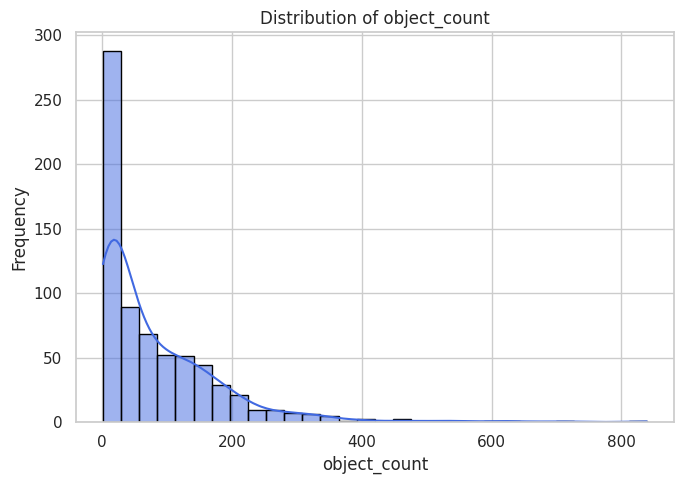

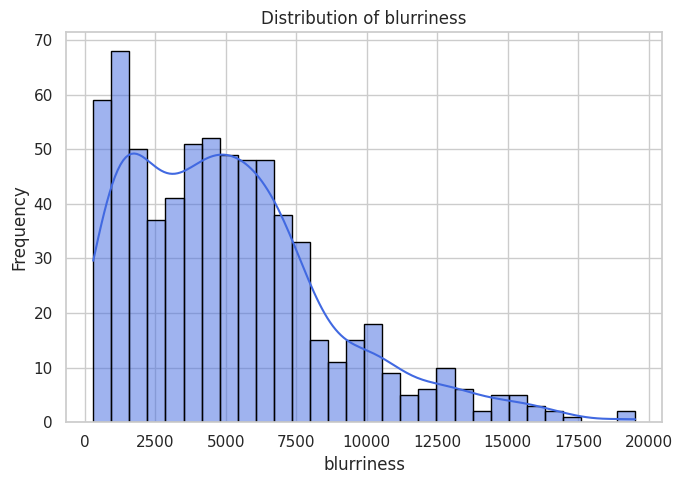

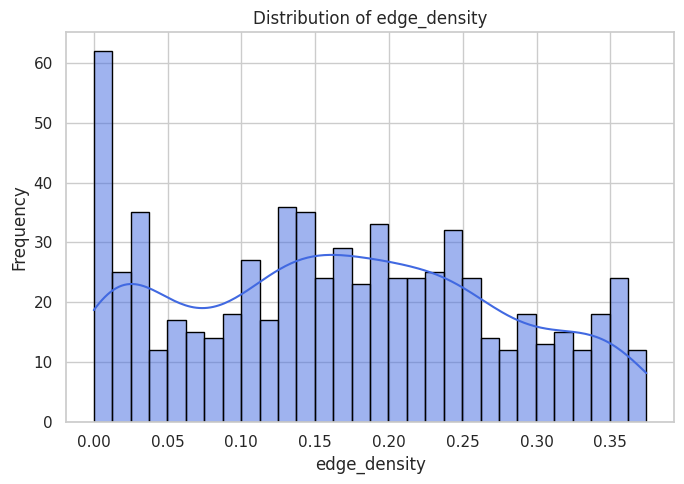

Metric visualizations completed and saved to: /content/drive/MyDrive/thesis/data/results


In [36]:
visualize_metrics_from_csv(
    csv_path="preprocessing_analysis_results.csv",
    save_dir=results_path,
    show_figures=True
)

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_color_and_brightness_contrast(csv_path, save_dir="metrics_visualization"):
    """
    Visualize mean/std of RGB channels (side-by-side and combined), brightness, and contrast.
    - Mean RGB: 1 row, 4 columns (R, G, B, all)
    - Std RGB:  1 row, 4 columns (R, G, B, all)
    - Brightness and Contrast: 2 histograms
    """
    os.makedirs(save_dir, exist_ok=True)
    df = pd.read_csv(csv_path)
    # Make sure all used columns are float
    for col in ["mean_R", "mean_G", "mean_B", "std_R", "std_G", "std_B", "brightness", "contrast"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    #### 1. Mean RGB side-by-side and combined
    fig, axs = plt.subplots(1, 4, figsize=(18, 4))
    for i, col in enumerate(['mean_R', 'mean_G', 'mean_B']):
        axs[i].hist(df[col].dropna(), bins=30, alpha=0.8, color=['red', 'green', 'blue'][i], edgecolor='black')
        axs[i].set_title(f"Mean {col[-1]}")
        axs[i].set_xlabel("Value")
        axs[i].set_ylabel("Frequency")
    # Combined plot
    axs[3].hist(df['mean_R'].dropna(), bins=30, alpha=0.5, color='red', label="R")
    axs[3].hist(df['mean_G'].dropna(), bins=30, alpha=0.5, color='green', label="G")
    axs[3].hist(df['mean_B'].dropna(), bins=30, alpha=0.5, color='blue', label="B")
    axs[3].set_title("Mean RGB Combined")
    axs[3].set_xlabel("Value")
    axs[3].set_ylabel("Frequency")
    axs[3].legend()
    fig.suptitle("Mean RGB Channel Distributions")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.savefig(os.path.join(save_dir, "mean_rgb_channels.png"))
    # plt.close(fig)

    #### 2. Std RGB side-by-side and combined
    fig, axs = plt.subplots(1, 4, figsize=(18, 4))
    for i, col in enumerate(['std_R', 'std_G', 'std_B']):
        axs[i].hist(df[col].dropna(), bins=30, alpha=0.8, color=['red', 'green', 'blue'][i], edgecolor='black')
        axs[i].set_title(f"Std {col[-1]}")
        axs[i].set_xlabel("Value")
        axs[i].set_ylabel("Frequency")
    # Combined plot
    axs[3].hist(df['std_R'].dropna(), bins=30, alpha=0.5, color='red', label="R")
    axs[3].hist(df['std_G'].dropna(), bins=30, alpha=0.5, color='green', label="G")
    axs[3].hist(df['std_B'].dropna(), bins=30, alpha=0.5, color='blue', label="B")
    axs[3].set_title("Std RGB Combined")
    axs[3].set_xlabel("Value")
    axs[3].set_ylabel("Frequency")
    axs[3].legend()
    fig.suptitle("Std RGB Channel Distributions")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.savefig(os.path.join(save_dir, "std_rgb_channels.png"))
    # plt.close(fig)

    #### 3. Brightness histogram
    plt.figure(figsize=(7,4))
    plt.hist(df["brightness"].dropna(), bins=30, color='gray', edgecolor='black')
    plt.title("Brightness Distribution (Mean Grayscale)")
    plt.xlabel("Brightness")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "brightness_hist.png"))
    # plt.close()

    #### 4. Contrast histogram
    plt.figure(figsize=(7,4))
    plt.hist(df["contrast"].dropna(), bins=30, color='black', edgecolor='gray')
    plt.title("Contrast Distribution (Grayscale Std)")
    plt.xlabel("Contrast")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "contrast_hist.png"))
    # plt.close()

    print(f"Saved plots to {save_dir}")

Saved plots to /content/drive/MyDrive/thesis/data/results


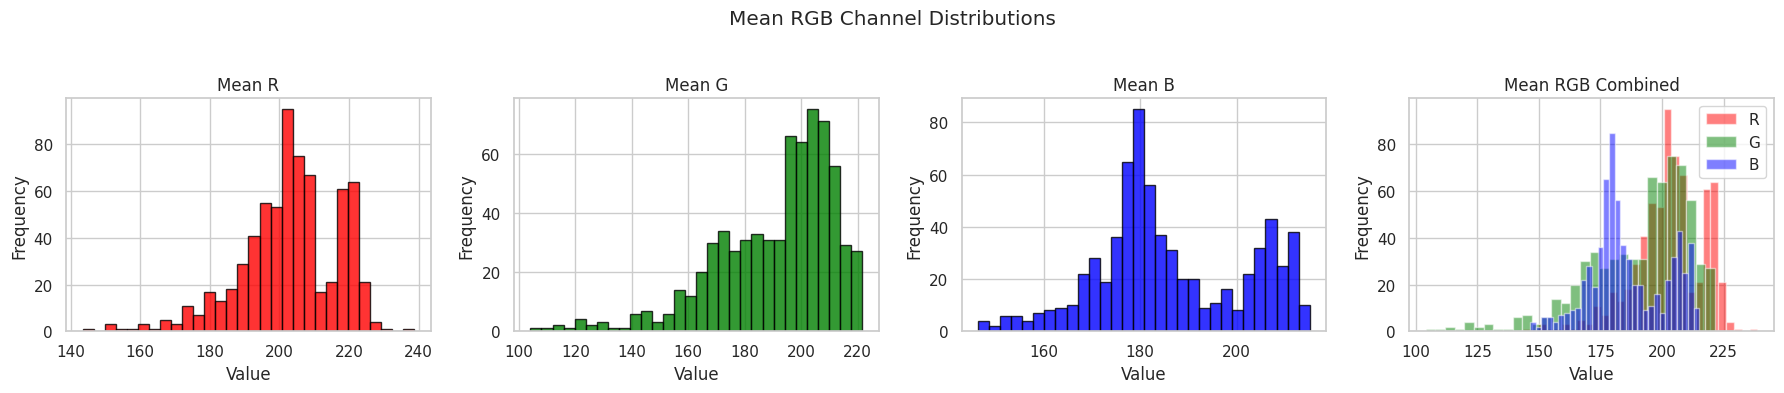

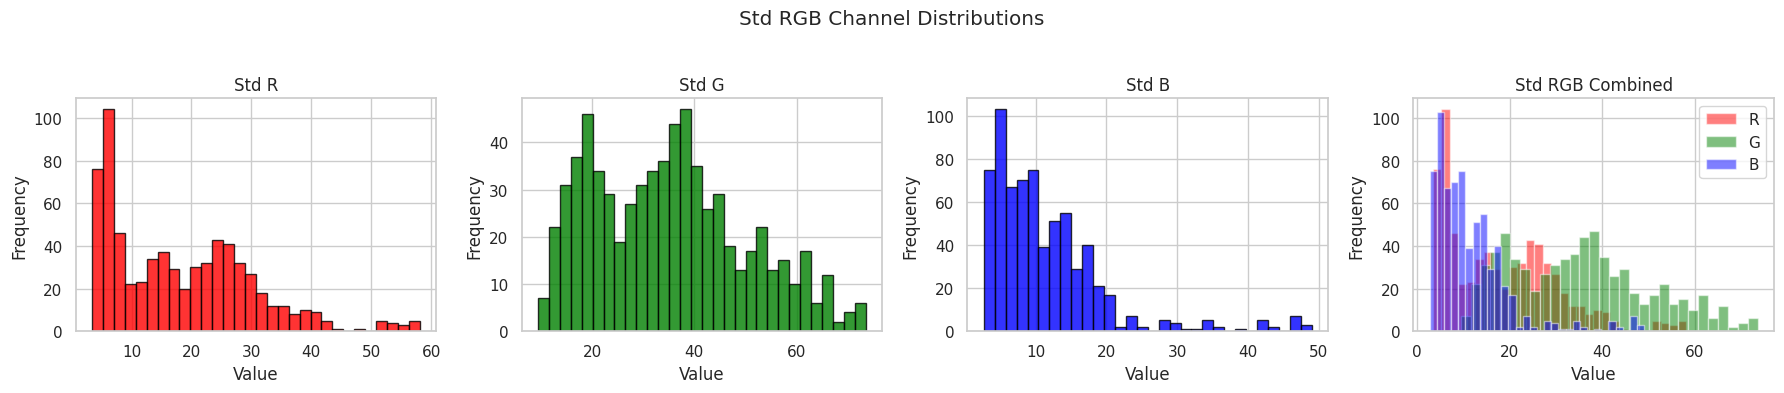

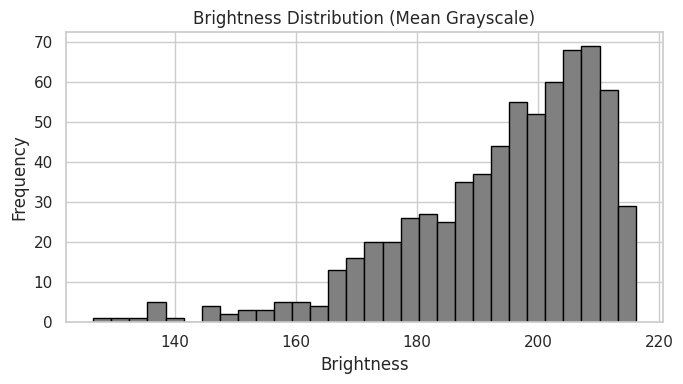

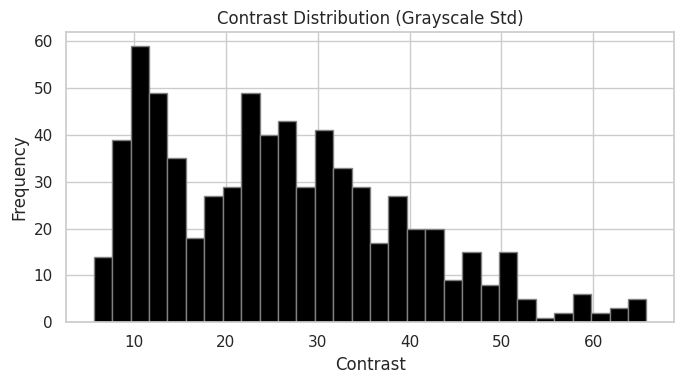

In [13]:
    plot_color_and_brightness_contrast(
        csv_path="preprocessing_analysis_results.csv",
        save_dir=results_path
    )

In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_blurriness_objectcount_edgedensity(csv_path, save_dir="metrics_visualization"):
    """
    Visualize distributions for blurriness, object_count, and edge_density.
    - Each: histogram with appropriate formatting
    - Combined: overlayed histogram for visual comparison
    """
    os.makedirs(save_dir, exist_ok=True)
    df = pd.read_csv(csv_path)
    for col in ["blurriness", "object_count", "edge_density"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    #### 1. Blurriness histogram
    plt.figure(figsize=(7,4))
    plt.hist(df["blurriness"].dropna(), bins=30, color='purple', edgecolor='black')
    plt.title("Blurriness Distribution (Laplacian Variance)")
    plt.xlabel("Blurriness")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "blurriness_hist.png"))
    plt.close()

    #### 2. Object count histogram
    plt.figure(figsize=(7,4))
    plt.hist(df["object_count"].dropna(), bins=30, color='orange', edgecolor='black')
    plt.title("Object Count Distribution")
    plt.xlabel("Object Count")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "object_count_hist.png"))
    plt.close()

    #### 3. Edge density histogram
    plt.figure(figsize=(7,4))
    plt.hist(df["edge_density"].dropna(), bins=30, color='teal', edgecolor='black')
    plt.title("Edge Density Distribution")
    plt.xlabel("Edge Density")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "edge_density_hist.png"))
    plt.close()

    #### 4. Combined plot: all three in one
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # Blurriness
    axs[0].hist(df["blurriness"].dropna(), bins=30, color='purple', edgecolor='black')
    axs[0].set_title("Blurriness (Laplacian Variance)")
    axs[0].set_xlabel("Blurriness")
    axs[0].set_ylabel("Frequency")

    # Object Count
    axs[1].hist(df["object_count"].dropna(), bins=30, color='orange', edgecolor='black')
    axs[1].set_title("Object Count")
    axs[1].set_xlabel("Object Count")
    axs[1].set_ylabel("Frequency")

    # Edge Density
    axs[2].hist(df["edge_density"].dropna(), bins=30, color='teal', edgecolor='black')
    axs[2].set_title("Edge Density")
    axs[2].set_xlabel("Edge Density")
    axs[2].set_ylabel("Frequency")

    fig.suptitle("Blurriness, Object Count, Edge Density Distributions")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.savefig(os.path.join(save_dir, "blur_objcount_edgedensity.png"))
    # plt.close(fig)

    print(f"Saved blurriness/object count/edge density plots to {save_dir}")

Saved blurriness/object count/edge density plots to /content/drive/MyDrive/thesis/data/results


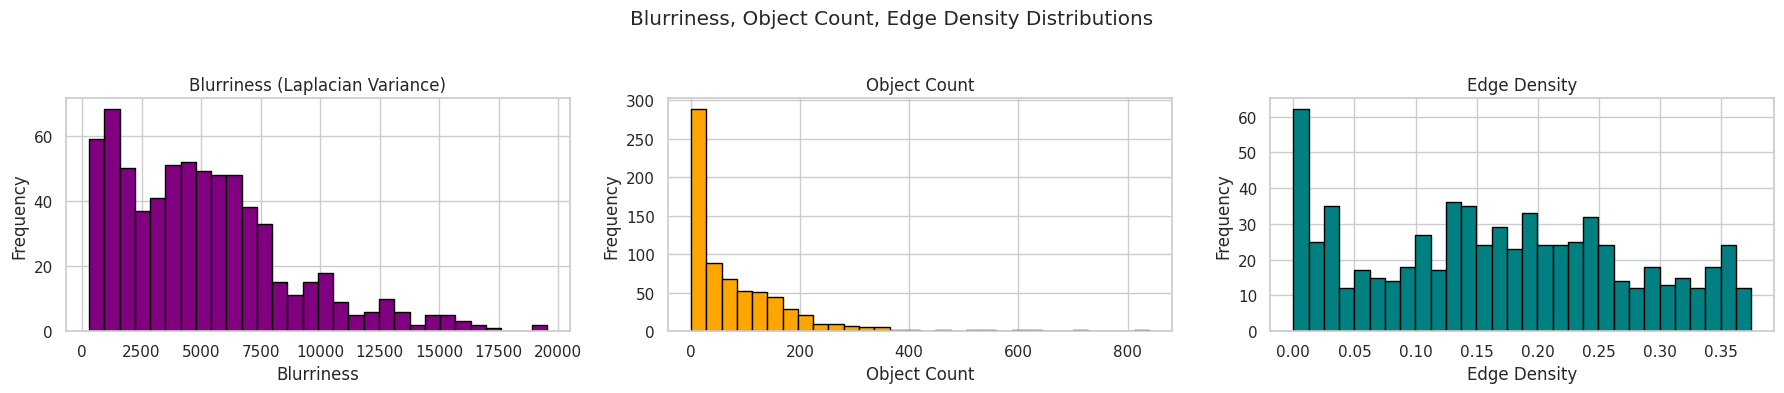

In [21]:
plot_blurriness_objectcount_edgedensity(
    csv_path="preprocessing_analysis_results.csv",
    save_dir=results_path
)

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_hue_saturation_metrics(csv_path, save_dir="metrics_visualization"):
    """
    Visualize distributions for mean_Hue, std_Hue, mean_Sat, std_Sat.
    Each: histogram. Arranged in a single row (1x4).
    """
    os.makedirs(save_dir, exist_ok=True)
    df = pd.read_csv(csv_path)
    for col in ["mean_Hue", "std_Hue", "mean_Sat", "std_Sat"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    fig, axs = plt.subplots(1, 4, figsize=(20, 4))

    # mean_Hue
    plt.figure(figsize=(7, 4))
    plt.hist(df["mean_Hue"].dropna(), bins=30, color='violet', edgecolor='black')
    plt.title("Mean Hue Distribution")
    plt.xlabel("mean_Hue")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "mean_Hue_hist.png"))
    plt.close()

    # std_Hue
    plt.figure(figsize=(7, 4))
    plt.hist(df["std_Hue"].dropna(), bins=30, color='purple', edgecolor='black')
    plt.title("Std Hue Distribution")
    plt.xlabel("std_Hue")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "std_Hue_hist.png"))
    plt.close()

    # mean_Sat
    plt.figure(figsize=(7, 4))
    plt.hist(df["mean_Sat"].dropna(), bins=30, color='gold', edgecolor='black')
    plt.title("Mean Saturation Distribution")
    plt.xlabel("mean_Sat")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "mean_Sat_hist.png"))
    plt.close()

    # std_Sat
    plt.figure(figsize=(7, 4))
    plt.hist(df["std_Sat"].dropna(), bins=30, color='orange', edgecolor='black')
    plt.title("Std Saturation Distribution")
    plt.xlabel("std_Sat")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "std_Sat_hist.png"))
    plt.close()

    axs[0].hist(df["mean_Hue"].dropna(), bins=30, color='violet', edgecolor='black')
    axs[0].set_title("Mean Hue")
    axs[0].set_xlabel("mean_Hue")
    axs[0].set_ylabel("Frequency")
    axs[1].hist(df["std_Hue"].dropna(), bins=30, color='purple', edgecolor='black')
    axs[1].set_title("Std Hue")
    axs[1].set_xlabel("std_Hue")
    axs[1].set_ylabel("Frequency")
    axs[2].hist(df["mean_Sat"].dropna(), bins=30, color='gold', edgecolor='black')
    axs[2].set_title("Mean Saturation")
    axs[2].set_xlabel("mean_Sat")
    axs[2].set_ylabel("Frequency")
    axs[3].hist(df["std_Sat"].dropna(), bins=30, color='orange', edgecolor='black')
    axs[3].set_title("Std Saturation")
    axs[3].set_xlabel("std_Sat")
    axs[3].set_ylabel("Frequency")

    fig.suptitle("Hue and Saturation Metric Distributions")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.savefig(os.path.join(save_dir, "side_by_side_hue_saturation.png"))
    # plt.close(fig)
    print(f"Saved side-by-side hue/saturation plots to {save_dir}")

Saved side-by-side hue/saturation plots to /content/drive/MyDrive/thesis/data/results


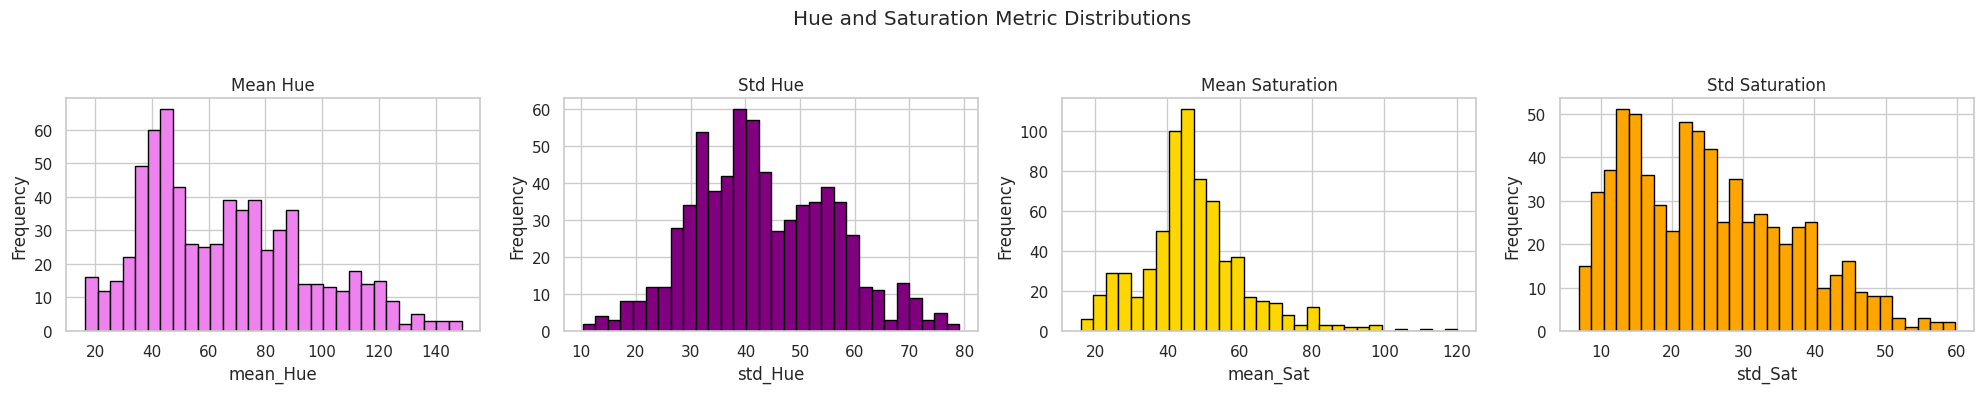

In [25]:
plot_hue_saturation_metrics(
    csv_path="preprocessing_analysis_results.csv",
    save_dir=results_path
)

In [17]:
import pandas as pd
import albumentations as A
import numpy as np
import json

def compute_auto_thresholds(df, metric, method="percentile", low_q=20, high_q=80, std_factor=1.0):
    vals = df[metric].dropna()
    if method == "percentile":
        low = np.percentile(vals, low_q)
        high = np.percentile(vals, high_q)
    elif method == "std":
        mean = vals.mean()
        std = vals.std()
        low = mean - std_factor * std
        high = mean + std_factor * std
    else:
        low = vals.min()
        high = vals.max()
    return low, high

def load_metric_stats_and_thresholds(csv_path):
    df = pd.read_csv(csv_path)
    stats = {}
    thresholds = {}
    metrics = ['blurriness', 'object_count', 'edge_density', 'mean_Hue', 'std_Hue', 'mean_Sat', 'std_Sat']
    for metric in metrics:
        if metric in df.columns:
            vals = df[metric].dropna()
            stats[metric] = {
                'mean': float(vals.mean()),
                'std': float(vals.std()),
                'min': float(vals.min()),
                'max': float(vals.max()),
                '25%': float(np.percentile(vals, 25)),
                '50%': float(np.percentile(vals, 50)),
                '75%': float(np.percentile(vals, 75)),
            }
            thresholds[metric] = {
                "low": float(compute_auto_thresholds(df, metric, method="percentile", low_q=20, high_q=80)[0]),
                "high": float(compute_auto_thresholds(df, metric, method="percentile", low_q=20, high_q=80)[1])
            }
    return stats, thresholds

def custom_augmentation_config(stats, thresholds):
    config = {
        "augmentations": []
    }

    # Blurriness-based blur
    blur_mean = stats.get('blurriness', {}).get('mean', None)
    blur_high = thresholds.get('blurriness', {}).get('high', None)
    if blur_mean is not None and blur_high is not None and blur_mean > blur_high:
        pass
    else:
        config["augmentations"].append({"type": "MotionBlur", "blur_limit": 3, "p": 0.15})

    # Edge density-based crop
    edge_mean = stats.get('edge_density', {}).get('mean', None)
    edge_high = thresholds.get('edge_density', {}).get('high', None)
    if edge_mean is not None and edge_high is not None and edge_mean > edge_high:
        config["augmentations"].append({
            "type": "RandomResizedCrop",
            "height": 224, "width": 224, "scale": [0.80, 1.15], "p": 0.6
        })
    else:
        config["augmentations"].append({
            "type": "CenterCrop",
            "height": 224, "width": 224, "p": 0.5
        })

    # Color jitter based on color std
    color_std_high = max(
        thresholds.get('std_Hue', {}).get('high', 0),
        thresholds.get('std_Sat', {}).get('high', 0),
    )
    color_var = max(stats.get('std_Hue', {}).get('mean', 0), stats.get('std_Sat', {}).get('mean', 0))
    if color_var > color_std_high:
        config["augmentations"].append({
            "type": "ColorJitter",
            "brightness": 0.15, "contrast": 0.15, "saturation": 0.15, "hue": 0.04, "p": 0.6
        })
    else:
        config["augmentations"].append({
            "type": "ColorJitter",
            "brightness": 0.05, "contrast": 0.05, "saturation": 0.05, "hue": 0.01, "p": 0.4
        })

    # Object count-based crop
    obj_count_mean = stats.get('object_count', {}).get('mean', None)
    obj_count_high = thresholds.get('object_count', {}).get('high', None)
    if obj_count_mean is not None and obj_count_high is not None and obj_count_mean > obj_count_high:
        config["augmentations"].append({
            "type": "RandomCrop",
            "height": int(224 * 0.9), "width": int(224 * 0.9), "p": 0.5
        })

    # Always basic augmentations
    config["augmentations"].extend([
        {"type": "HorizontalFlip", "p": 0.5},
        {"type": "VerticalFlip", "p": 0.5},
        {"type": "Rotate", "limit": 15, "p": 0.7},
        {"type": "GaussNoise", "var_limit": [5.0, 20.0], "p": 0.2}
    ])

    config["metric_stats"] = stats
    config["metric_thresholds"] = thresholds
    return config

def save_config_json(config, outpath="augmentation_config.json"):
    with open(outpath, "w") as f:
        json.dump(config, f, indent=2)
    print(f"Wrote config to {outpath}")

In [19]:
csv_path = "preprocessing_analysis_results_clinical.csv"
stats, thresholds = load_metric_stats_and_thresholds(csv_path)
config = custom_augmentation_config(stats, thresholds)
save_config_json(config, "augmentation_config.json")

Wrote config to augmentation_config.json


In [20]:
import json
import albumentations as A
import cv2
import os
from glob import glob
from tqdm import tqdm

def build_augmentation_pipeline(json_config):
    aug_list = []
    for aug in json_config["augmentations"]:
        aug_type = aug.get("type")
        params = {k: v for k, v in aug.items() if k != "type"}
        if hasattr(A, aug_type):
            aug_class = getattr(A, aug_type)
            aug_list.append(aug_class(**params))
        else:
            print(f"Warning: Unknown augmentation type {aug_type}, skipping.")
    return A.Compose(aug_list, p=1.0)

def optimized_num_augmentations(original_count, target_count=20000):
    """
    Suggest an optimized and justifiable number of augmentations per image.
    - If dataset is small: more augmentations per image.
    - If dataset is large: fewer augmentations per image.
    - Default target_count is 20,000 (good for most deep learning tasks).
    """
    if original_count >= target_count:
        return 1  # No need to expand
    # Cap at 10 to avoid excessive redundancy
    n_aug = min(max(target_count // original_count, 2), 10)
    return n_aug

def apply_augmentations(input_dir, output_dir, pipeline, n_aug=5, image_size=(224,224), save_ext=".png"):
    os.makedirs(output_dir, exist_ok=True)
    image_paths = glob(os.path.join(input_dir, "*"))
    for img_path in tqdm(image_paths):
        img = cv2.imread(img_path)
        if img is None:
            print(f"Skipping unreadable image: {img_path}")
            continue
        # Resize first (standardize input)
        img = cv2.resize(img, image_size)
        base = os.path.splitext(os.path.basename(img_path))[0]
        for i in range(n_aug):
            augmented = pipeline(image=img)
            img_aug = augmented["image"]
            if img_aug.dtype != 'uint8':
                img_aug = (img_aug.clip(0, 255)).astype('uint8')
            out_path = os.path.join(output_dir, f"{base}_aug{i}{save_ext}")
            cv2.imwrite(out_path, img_aug)
    print(f"Saved {len(image_paths) * n_aug} images to {output_dir}")

In [21]:
    output_dir = f"{data_dir}/augmented/clinical_pb"
    json_path = "augmentation_config.json"
    image_size = (224, 224)

    # Load augmentation config
    with open(json_path, "r") as f:
        aug_config = json.load(f)
    pipeline = build_augmentation_pipeline(aug_config)

    # Determine optimized number of augmentations per image
    original_count = len(glob(os.path.join(dibas_path, "*")))
    n_aug = optimized_num_augmentations(original_count, target_count=20000)
    print(f"Original images: {original_count}")
    print(f"Augmentations per image: {n_aug} (target dataset size: ~{original_count * n_aug})")

    # Apply augmentations and expand dataset
    apply_augmentations(clinical_path, output_dir, pipeline, n_aug=n_aug, image_size=image_size)

<ipython-input-20-e5b20b1ded1f>:15: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  aug_list.append(aug_class(**params))


Original images: 692
Augmentations per image: 10 (target dataset size: ~6920)


100%|██████████| 55/55 [00:11<00:00,  4.77it/s]

Saved 550 images to /content/drive/MyDrive/thesis/data/augmented/clinical_pb


In [43]:
import pandas as pd

# Load the data
dibas_df = pd.read_csv('preprocessing_analysis_results.csv')
clinic_df = pd.read_csv('preprocessing_analysis_results_clinical.csv')

# Add a column to identify the dataset
dibas_df['Dataset'] = 'DIBaS'
clinic_df['Dataset'] = 'Clinical-pb'

# Combine the two DataFrames
combined_df = pd.concat([dibas_df, clinic_df], ignore_index=True)

# Reorder columns to have 'Dataset' first (optional)
cols = ['Dataset'] + [col for col in combined_df if col != 'Dataset']
combined_df = combined_df[cols]

# Print summary statistics for each dataset
summary = combined_df.groupby('Dataset').describe(include='all')

print("=== Summary Table by Dataset ===")
print(summary)

# Optionally, save the combined and summary tables
combined_df.to_csv('combined_analysis_results.csv', index=False)
summary.to_csv('summary_analysis_results_by_dataset.csv')

=== Summary Table by Dataset ===
            filename                                                          \
               count unique                               top freq mean  std   
Dataset                                                                        
Clinical-pb       55     55                            12.jpg    1  NaN  NaN   
DIBaS            689    689  Propionibacterium.acnes_0022.tif    1  NaN  NaN   

                                 ... edge_density                     \
             min  25%  50%  75%  ...       unique top freq      mean   
Dataset                          ...                                   
Clinical-pb  NaN  NaN  NaN  NaN  ...          NaN NaN  NaN  0.104725   
DIBaS        NaN  NaN  NaN  NaN  ...          NaN NaN  NaN  0.166968   

                                                                        
                  std       min       25%       50%       75%      max  
Dataset                                                    

In [44]:
import pandas as pd

# Load your CSVs
dibas_df = pd.read_csv('preprocessing_analysis_results.csv')
clinical_df = pd.read_csv('preprocessing_analysis_results_clinical.csv')

# Add a dataset column
dibas_df['Dataset'] = 'DIBaS'
clinical_df['Dataset'] = 'Clinical-pb'

# Concatenate
all_df = pd.concat([dibas_df, clinical_df], ignore_index=True)

# Group by dataset and compute the mean (numeric columns only)
mean_summary = all_df.groupby("Dataset").mean(numeric_only=True)

# Print or save the results
print("=== Average (Mean) of Features by Dataset ===")
print(mean_summary.T)  # Transposed for readability

# Optional: Save to CSV
mean_summary.to_csv("average_features_by_dataset.csv")

=== Average (Mean) of Features by Dataset ===
Dataset       Clinical-pb        DIBaS
mean_R         204.420943   202.992941
mean_G         194.768481   190.985022
mean_B         180.738883   185.919081
std_R           19.801692    18.201207
std_G           27.272240    35.016928
std_B           17.309245    11.495122
mean_Hue        47.751447    66.041164
std_Hue         35.587965    43.309294
mean_Sat        40.723051    47.069538
std_Sat         15.756241    25.132249
brightness     196.054492   193.999402
contrast        23.396539    26.200938
object_count    41.163636    80.946299
blurriness    2799.988393  5120.068475
edge_density     0.104725     0.166968


# Miscellenous

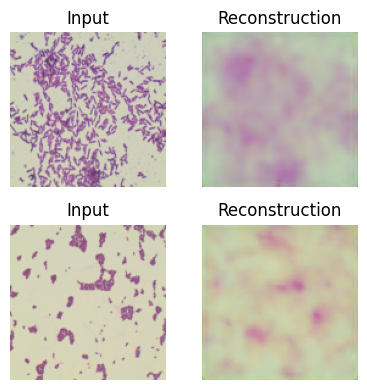

In [52]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# --- User configuration ---
MODEL_PATH = 'best_model.pt'
BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = (128, 128)
NUM_PAIRS = 2  # Number of pairs to visualize

# --- Assume CombinedImageFolderDataset from your code is available ---
folders = [dibas_path]
DATASET = CombinedImageFolderDataset(folders, (128, 128))

# --- Load model (assume CAE class is already imported/defined) ---
model = CAE(latent_dim=64)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval().to(DEVICE)

# --- Data loader ---
loader = DataLoader(DATASET, batch_size=BATCH_SIZE, shuffle=False)

# --- Visualization ---
def denorm(img_tensor):
    # Undo ToTensor() and normalization (assuming range [0, 1])
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)
    return img

# Get a single batch of images
with torch.no_grad():
    imgs = next(iter(loader))
    imgs = imgs[:NUM_PAIRS].to(DEVICE)
    recons, _ = model(imgs)
    imgs = imgs.cpu()
    recons = recons.cpu()

# Plot input–reconstruction pairs
fig, axes = plt.subplots(NUM_PAIRS, 2, figsize=(4, 2 * NUM_PAIRS))
for i in range(NUM_PAIRS):
    axes[i, 0].imshow(denorm(imgs[i]))
    axes[i, 0].set_title("Input")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(denorm(recons[i]))
    axes[i, 1].set_title("Reconstruction")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.savefig(f"{results_path}/input_reconstruction_pairs.png")
plt.show()